In [34]:
%cd /Users/gwg/dmcm
%matplotlib inline

/Users/gwg/dmcm


In [35]:
import numpy as np
import torch
import random
import matplotlib
import matplotlib.pyplot as plt
from   PIL import Image

In [36]:
directory = '/Users/gwg/dmcm/experiments/20190128_big_sweep/'\
            'gtexv8_mode-dpcca_batch_size-%s_seed-0_latent_dim-2_lr-1e-05_'\
            'l1_coef-1.0_private_z-1_linear_gene_enc-1_clip-1'

fname_128 = (directory % '128') + '/out.txt'
fname_256 = (directory % '256') + '/out.txt'

fname_128 = (directory % '128') + '/out.txt'
fname_256 = (directory % '256') + '/out.txt'

In [37]:
def get_curve(fname):
    
    with open(fname) as out:
        lines = [l.strip() for l in out]

    idx = None
    for i, l in enumerate(lines):
        if l == 'Training model.':
            idx = i+2

    losses = lines[idx:]
    img_curve = []
    gen_curve = []
    nll_curve = []
    for l in losses:
        try:
            parts = l.split('\t')
            # train indices: 2, 3, 5
            # test indices : 7, 8, 10
            img_curve.append(float(parts[7]))
            gen_curve.append(float(parts[8]))
            nll_curve.append(float(parts[10]))
        except:
            pass
            
    return img_curve, gen_curve, nll_curve

img_curve_128, gen_curve_128, nll_curve_128 = get_curve(fname_128)
img_curve_256, gen_curve_256, nll_curve_256 = get_curve(fname_256)

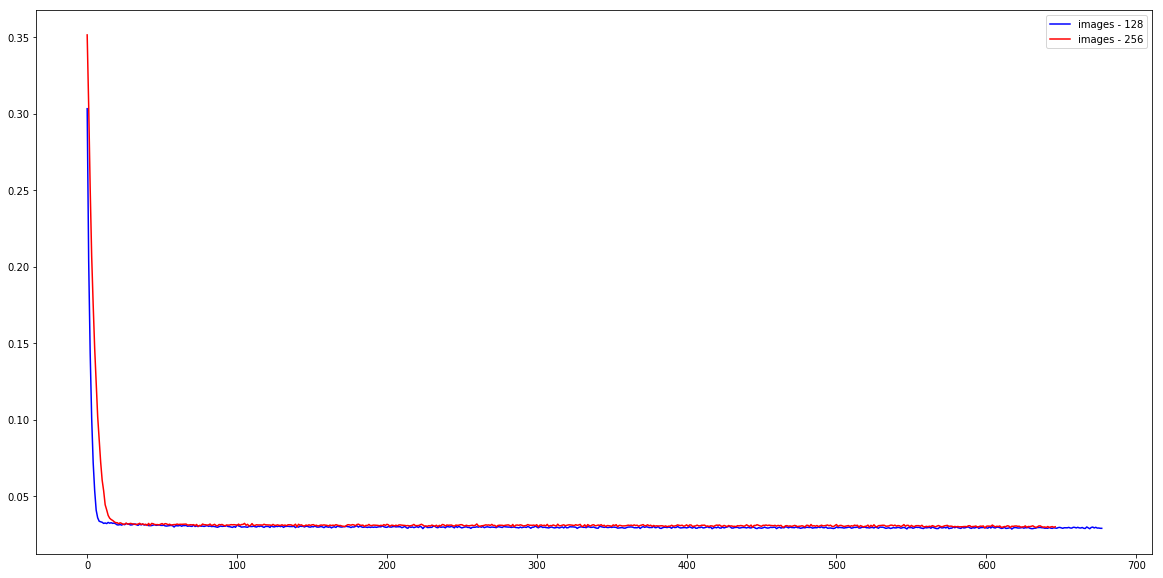

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

x = list(range(len(img_curve_128)))
y = img_curve_128
plt.plot(x, y, color='blue', label='images - 128')
x = list(range(len(img_curve_256)))
y = img_curve_256
plt.plot(x, y, color='red', label='images - 256')
plt.legend()

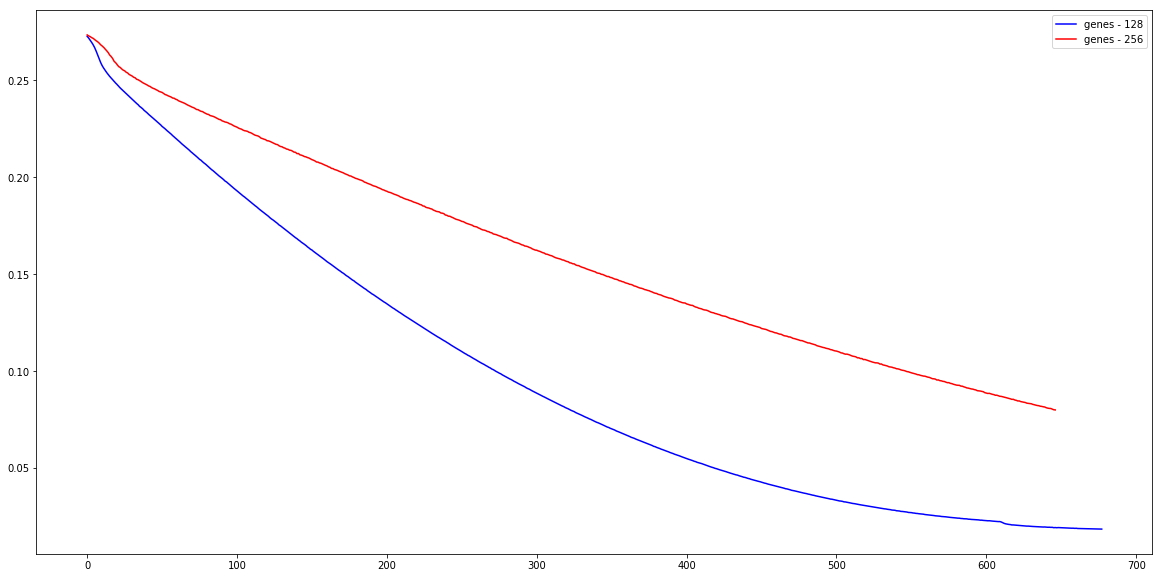

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

gen_curve_128_ = gen_curve_128#[150:]
gen_curve_256_ = gen_curve_256#[150:]

x = list(range(len(gen_curve_128_)))
y = gen_curve_128_
plt.plot(x, y, color='blue', label='genes - 128')
x = list(range(len(gen_curve_256_)))
y = gen_curve_256_
plt.plot(x, y, color='red', label='genes - 256')
plt.legend()

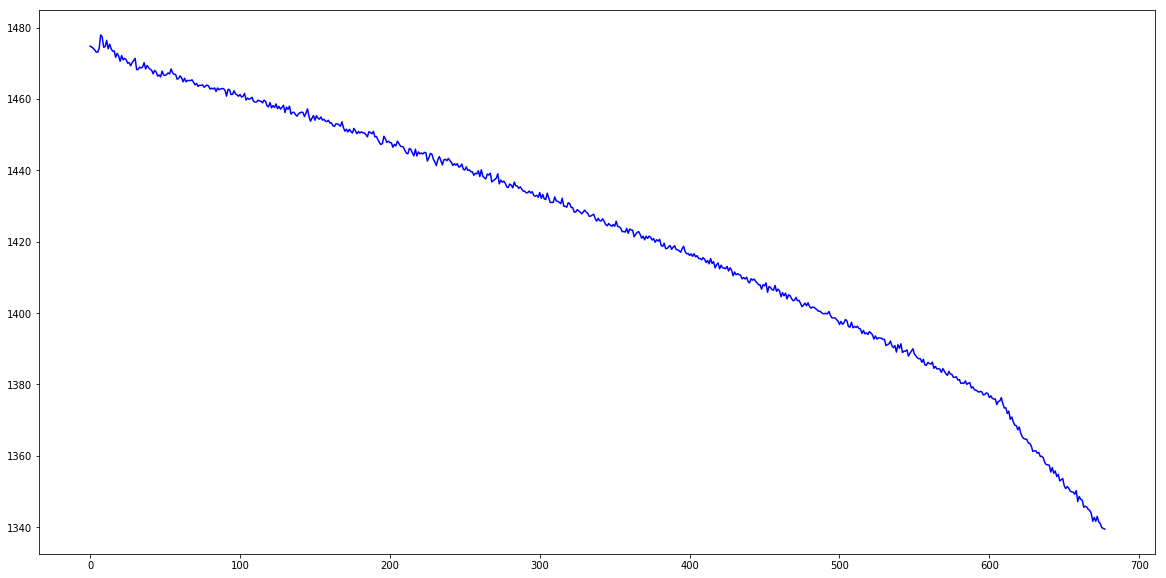

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

x = list(range(len(nll_curve_128)))
y = nll_curve_128
plt.plot(x, y, color='blue', label='nll - 128')
# x = list(range(len(nll_curve_256)))
# y = nll_curve_256
# plt.plot(x, y, color='red', label='nll - 256')
# plt.legend()

In [43]:
from   data import GTExV8Config, GTExV8Dataset, loader
from   models import DCGANAE128, DPCCA

cfg = GTExV8Config()

state = torch.load(directory % '128' + '/model.pt', map_location={'cuda:0': 'cpu'})
model_128 = DPCCA(cfg, latent_dim=2, private_z=True, linear_gene_enc=True)
model_128.load_state_dict(state)

# state = torch.load(directory % '256' + '/model.pt', map_location={'cuda:0': 'cpu'})
# model_256 = DPCCA(cfg, latent_dim=2, private_z=True, linear_gene_enc=True)
# model_256.load_state_dict(state)

In [44]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    cv_pct=0.2)
dataset = GTExV8Dataset(cfg)

In [46]:
inds = test_loader.sampler.indices
n    = len(inds)
X1   = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2   = torch.Tensor(n, cfg.N_GENES)

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2

In [47]:
nll_128 = model_128.neg_log_likelihood([X1, X2])
# nll_256 = model_256.neg_log_likelihood([X1, X2])
print(nll_128)

234877.75 223278.890625
